In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from cvxopt import matrix, solvers
from sklearn.decomposition import PCA



In [6]:
training_data = pd.read_csv('mnist_train.csv')
testing_data = pd.read_csv('mnist_test.csv')

In [10]:
X_train = training_data.iloc[:, 1:].values
y_train = training_data.iloc[:, 0].values
X_test = testing_data.iloc[:, 1:].values
y_test = testing_data.iloc[:, 0].values

In [12]:
X_train = X_train / 255.0
X_test = X_test / 255.0



In [13]:
def select_classes(X, y, class1, class2):
    indices = np.where((y == class1) | (y == class2))
    X = X[indices]
    y = y[indices]
    y = np.where(y == class1, -1, 1)  # Convert labels to -1 and 1
    return X, y

In [14]:
X_train, y_train = select_classes(X_train, y_train, 0, 1)
X_test, y_test = select_classes(X_test, y_test, 0, 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [15]:
class SVM:
    def __init__(self, C=1.0):
        self.C = C  
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        K = np.dot(X, X.T)

        
        P = matrix(np.outer(y, y) * K, tc='d')
        q = matrix(-np.ones(n_samples), tc='d')
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))), tc='d')
        h = matrix(np.hstack((np.zeros(n_samples), self.C * np.ones(n_samples))), tc='d')
        A = matrix(y.reshape(1, -1), tc='d')
        b = matrix(0.0, tc='d')

       
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(solution['x'])

       
        sv_indices = alphas > 0 
        self.alphas = alphas[sv_indices]
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = y[sv_indices]

        self.w = np.sum((self.alphas * self.support_vector_labels)[:, None] * self.support_vectors, axis=0)
        self.b = np.mean(
            self.support_vector_labels - np.dot(self.support_vectors, self.w)
        )

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

In [16]:
svm = SVM(C =1.0)
svm.fit(X_train, y_train)

In [17]:
y_pred_val = svm.predict(X_val)
y_pred_test = svm.predict(X_test)

In [18]:
print("Validation Metrics:")
print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("Precision:", precision_score(y_val, y_pred_val))
print("Recall:", recall_score(y_val, y_pred_val))
print("F1 Score:", f1_score(y_val, y_pred_val))

Validation Metrics:
Accuracy: 0.9996052112120016
Precision: 1.0
Recall: 0.9992679355783309
F1 Score: 0.9996338337605273


In [19]:
print("\nTest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))


Test Metrics:
Accuracy: 0.9990543735224586
Precision: 0.9982409850483729
Recall: 1.0
F1 Score: 0.9991197183098591


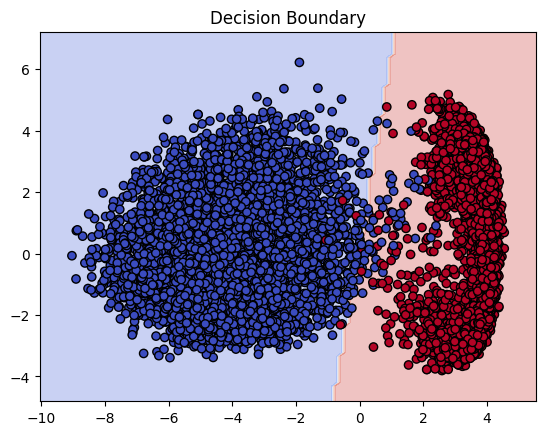

In [20]:
def plot_decision_boundary(X, y, model):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title("Decision Boundary")
    plt.show()

plot_decision_boundary(X_train, y_train, svm)